# PD - Probability of Default
This notebook will train a model to predict a likelihood of a borrower defaults (fail to pay back a certain debt). Let's start with feature selection


In [1]:
import os
import sys

# Data Science
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# dataframe set
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# from local
sys.path.append(os.path.abspath('../'))
from src.util import display_woe

np.random.seed(42)



## Feature selection
First, using the selected features from `simple_feature_selection.ipynb`

In [2]:
df = pd.read_csv('../data/original/loan_data.csv')
# %store -r FIRST_SELECTED_FEATURES
# df = df[FIRST_SELECTED_FEATURES]
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,...,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


To comply with regulatory requirements, PD models should be **explainable and interpretable**. In order to address this, it is recommended to develop a credit scorecard. This approach involves categorizing variables appropriately and determining how each category affects the Credit Score by assigning corresponding increases or decreases.

To implement this approach, categorical variables and binned numeric variables are utilized. Additionally, considering that certain variables may have a large number of unique values (high cardinality), it can be beneficial to examine how the categories relate to the target variable. In cases where it is reasonable, aggregating some categories may provide valuable insights.

The two concepts **weight of evidence (WOE) and information value (IV)** are also a good practice to screen features. 

With a limit resource, I decide to pick fewer features that I think is important which is listed below (mosts are from [kaggle](https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction)).

<table class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th></th>
      <th>LoanStatNew</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>loan_amnt</td>
      <td>The listed amount of the loan applied for by the borrower.</td>
    </tr>
    <tr>
      <th>1</th>
      <td>term</td>
      <td>The number of payments on the loan. Values are in months and can be either 36 or 60.</td>
    </tr>
    <tr>
      <th>2</th>
      <td>int_rate</td>
      <td>Interest Rate on the loan</td>
    </tr>
    <tr>
      <th>3</th>
      <td>installment</td>
      <td>The monthly payment owed by the borrower if the loan originates.</td>
    </tr>
    <tr>
      <th>4</th>
      <td>grade</td>
      <td>LC assigned loan grade</td>
    </tr>
    <tr>
      <th>5</th>
      <td>delinq_2yrs</td>
      <td>Number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.</td>
    </tr>
    <tr>
      <th>6</th>
      <td>emp_length</td>
      <td>Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</td>
    </tr>
    <tr>
      <th>7</th>
      <td>home_ownership</td>
      <td>The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
    </tr>
    <tr>
      <th>8</th>
      <td>annual_inc</td>
      <td>The self-reported annual income provided by the borrower during registration.</td>
    </tr>
    <tr>
      <th>9</th>
      <td>verification_status</td>
      <td>Indicates if income was verified by LC, not verified, or if the income source was verified</td>
    </tr>
    <tr>
      <th>10</th>
      <td>initial_list_status</td>
      <td>The initial listing status of the loan. Possible values are – W, F</td>
    </tr>
    <tr>
      <th>11</th>
      <td>loan_status</td>
      <td>Current status of the loan</td>
    </tr>
    <tr>
      <th>12</th>
      <td>purpose</td>
      <td>A category provided by the borrower for the loan request.</td>
    </tr>
    <tr>
      <th>13</th>
      <td>addr_state</td>
      <td>The state provided by the borrower in the loan application</td>
    </tr>
    <tr>
      <th>14</th>
      <td>dti</td>
      <td>A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.</td>
    </tr>
    <tr>
      <th>15</th>
      <td>inq_last_6mths</td>
      <td>Number of inquiries paid in last 6 months.</td>
    </tr>
    <tr>
      <th>16</th>
      <td>open_acc</td>
      <td>The number of open credit lines in the borrower's credit file.</td>
    </tr>
    <tr>
      <th>17</th>
      <td>pub_rec</td>
      <td>Number of derogatory public records</td>
    </tr>
    <tr>
      <th>18</th>
      <td>total_acc</td>
      <td>The total number of credit lines currently in the borrower's credit file</td>
    </tr>
    <tr>
      <th>19</th>
      <td>funded_amnt</td>
      <td>Total ammount commited to that loan at a point in time;</td>
    </tr>
  </tbody>
</table>

In [3]:
FINAL_SELECTED_FEATURES = [
    "id", "loan_amnt", "term", "int_rate", "installment", "grade", "emp_length", 
    "home_ownership", "annual_inc", "verification_status", "loan_status", "purpose", "addr_state", 
    "dti", "open_acc", "pub_rec", "total_acc", "initial_list_status", "delinq_2yrs", 
    "inq_last_6mths", "funded_amnt"
]

In [4]:
df = df[FINAL_SELECTED_FEATURES]

In [5]:
numerical_features = df.select_dtypes(include=['int', 'float']).columns

categorical_features = df.select_dtypes(include=['object']).columns

## Data Clean and Features Transform
Here is the summary of null values:

### Data Clean

In [6]:
df.isna().sum()

id                         0
loan_amnt                  4
term                       4
int_rate                   4
installment                4
grade                      4
emp_length             36906
home_ownership             4
annual_inc                 4
verification_status        4
loan_status                4
purpose                    4
addr_state                 5
dti                      354
open_acc                   5
pub_rec                    5
total_acc                  5
initial_list_status        5
delinq_2yrs                5
inq_last_6mths             5
funded_amnt                4
dtype: int64

Before cleaning the data or transforming the features, I need to convert the target value from `loan_status`. Here are all the values from `loan_status`

In [7]:
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan],
      dtype=object)

The value `Fully Paid` will be non-default, and the rest will be default. There are null values in loan_status, and it will be removed due to the fact that there are only 4/~500,000 records contain null value

In [8]:
df = df.dropna(subset=['loan_status'])

NON_DEFAULT_CATEGORIES = [
    "Fully Paid",
]
TARGET_VARIABLE = "default"

df[TARGET_VARIABLE] = df["loan_status"].isin(NON_DEFAULT_CATEGORIES).astype(float)

In [9]:
df[df['emp_length'].isnull()==True].to_csv('../log/missing_emp_length.csv', index=False)

Let's impute the emp_length with 0. We can go back and change them into othe quantitative values, but let's start with 0. 

In [10]:
df['emp_length'] = df['emp_length'].fillna('0')

Lastly, drop all records that have null `dti` since the contribution of null value from `dti` feature does not impact the distribution of the data. I will evaluate the missing values of `dti` after training the first model

In [11]:
# save it into log file
df[df['dti'].isnull()==True].to_csv('../log/missing_dti.csv', index=False)

# drop null
df = df.dropna(subset=['dti'])

### Features Transformation
The data set is clean. Now, we need to transfor the features. There are two type of features that need to transform:
- Numerical Features
- Categorical Features

Before that, we should split the data to avoid data leakage from train and test sets. Remember to set random seed to have reproducible product

In [12]:
# split data
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df[TARGET_VARIABLE])

# save the train and test in case you forgot set up random state
train_df.to_csv('../data/train/train.csv', index=False)

test_df.to_csv('../data/test/test.csv', index=False)

#### Categorical Features
now it's time to take a closer look at categorical features. We need to pick best categories for each features by WoE analysis. Here are features that we will analyze:
- grade
- home_ownership
- purpose
- addr_state
- verification_status 
- initial_list_status

1. grade

In [13]:
# check null and distribution
print(f"{train_df['grade'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['grade'].value_counts())

0.00% missing!


C    131658
B    131373
A     86156
D     67335
E     32623
F      8927
G      2268
Name: grade, dtype: int64


IV value: 0.8446331644016808


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
grade,,,,,,,
G,1428,840,2268,0.007269,0.003183,-0.825770,0.120662
F,5453,3474,8927,0.027758,0.013164,-0.746001,0.120662
E,18355,14268,32623,0.093434,0.054068,-0.547025,0.120662
D,35045,32290,67335,0.178393,0.122361,-0.377018,0.120662
C,60126,71532,131658,0.306066,0.271065,-0.121440,0.120662
B,49617,81756,131373,0.252571,0.309809,0.204264,0.120662
A,26424,59732,86156,0.134509,0.226350,0.520453,0.120662


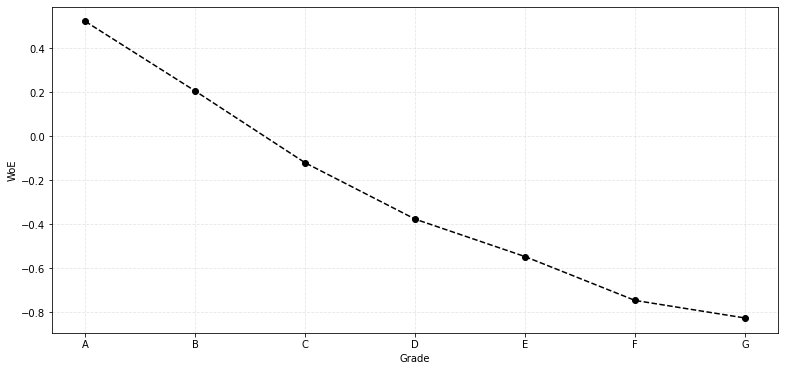

In [14]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='grade',
    target_column_name=TARGET_VARIABLE,
)


Considering the analysis conducted earlier, it has been determined that retaining the existing seven categories (A to G) is the preferred course of action. The observed trend demonstrates a nearly monotonically increasing curve, indicating that category A represents the highest score while category G represents the lowest score. Hence, the original values will be kept for one-hot encoding

2. home_ownership


In [ ]:
print(f"{train_df['home_ownership'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['home_ownership'].value_counts())

0.00% missing!


MORTGAGE    225718
RENT        182356
OWN          52261
ANY              5
Name: home_ownership, dtype: int64


In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='home_ownership',
    target_column_name=TARGET_VARIABLE,
)


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
home_ownership,,,,,,,
ANY,4,1,5,0.000020,0.000004,-1.681437,0.003527
RENT,80454,101902,182356,0.409543,0.386150,-0.058816,0.003527
OWN,22995,29266,52261,0.117054,0.110901,-0.053993,0.003527
MORTGAGE,92995,132723,225718,0.473382,0.502944,0.060576,0.003527


3. purpose

In [ ]:
print(f"{train_df['purpose'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['purpose'].value_counts())

0.00% missing!


debt_consolidation    265130
credit_card           108586
home_improvement       29190
other                  25918
major_purchase          9441
medical                 5108
car                     4365
small_business          4098
moving                  2812
house                   2720
vacation                2706
renewable_energy         258
wedding                    8
Name: purpose, dtype: int64


In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='purpose',
    target_column_name=TARGET_VARIABLE,
)

,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
purpose,,,,,,,
house,1590,1130,2720,0.008094,0.004282,-0.636659,0.009227
small_business,2101,1997,4098,0.010695,0.007567,-0.345910,0.009227
wedding,4,4,8,0.000020,0.000015,-0.295142,0.009227
other,12348,13570,25918,0.062856,0.051423,-0.200775,0.009227
medical,2380,2728,5108,0.012115,0.010338,-0.158674,0.009227
major_purchase,4386,5055,9441,0.022327,0.019156,-0.153182,0.009227
renewable_energy,117,141,258,0.000596,0.000534,-0.108556,0.009227
moving,1227,1585,2812,0.006246,0.006006,-0.039130,0.009227
debt_consolidation,113374,151756,265130,0.577120,0.575069,-0.003560,0.009227


4. addr_state

In [ ]:
print(f"{train_df['addr_state'].isnull().mean()*100:.2f}% missing!\n\n")
# print(train_df['addr_state'].value_counts())

0.00% missing!




IV value: 0.47071469311597386


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
addr_state,,,,,,,
ID,301,107,408,0.001532,0.000405,-1.329424,0.009414
NE,786,702,1488,0.004001,0.002660,-0.408166,0.009414
ME,449,403,852,0.002286,0.001527,-0.403228,0.009414
ND,341,337,678,0.001736,0.001277,-0.306942,0.009414
MS,1388,1543,2931,0.007065,0.005847,-0.189277,0.009414
AR,1615,1815,3430,0.008221,0.006878,-0.178392,0.009414
OK,1991,2288,4279,0.010135,0.008670,-0.156101,0.009414
SD,412,486,898,0.002097,0.001842,-0.129957,0.009414
LA,2481,2958,5439,0.012629,0.011209,-0.119291,0.009414


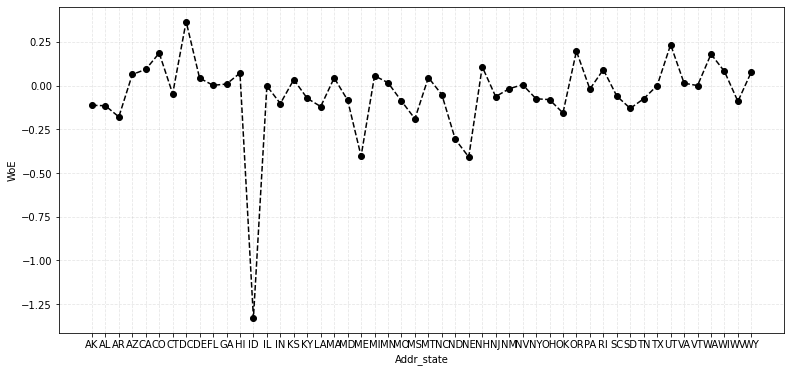

In [16]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='addr_state',
    target_column_name=TARGET_VARIABLE,
)

5. verification_status

In [ ]:
print(f"{train_df['verification_status'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['verification_status'].value_counts())

0.00% missing!


Source Verified    195102
Not Verified       137425
Verified           127813
Name: verification_status, dtype: int64


IV value: 0.001973684315954721


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
verification_status,,,,,,,
Verified,55716,72097,127813,0.283617,0.273206,-0.037397,0.000658
Not Verified,58673,78752,137425,0.298669,0.298425,-0.000818,0.000658
Source Verified,82059,113043,195102,0.417714,0.428368,0.025188,0.000658


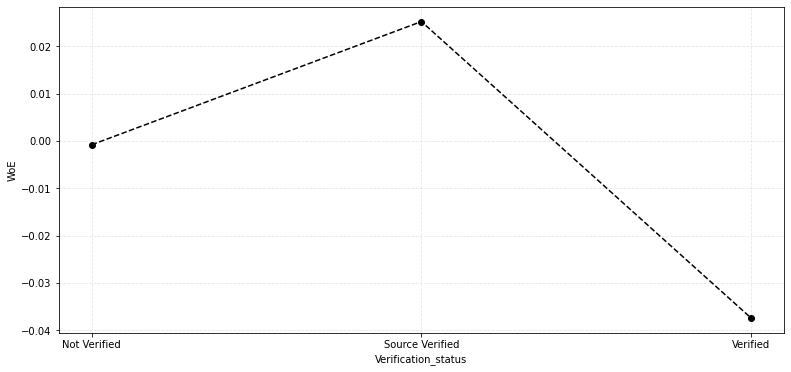

In [17]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='verification_status',
    target_column_name=TARGET_VARIABLE,
)

6. initial_list_status

In [ ]:
print(f"{train_df['initial_list_status'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['initial_list_status'].value_counts())

0.00% missing!


w    315528
f    144812
Name: initial_list_status, dtype: int64


In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='initial_list_status',
    target_column_name=TARGET_VARIABLE,
)

,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
initial_list_status,,,,,,,
w,145986,169542,315528,0.743128,0.642467,-0.145552,0.047935
f,50462,94350,144812,0.256872,0.357533,0.330649,0.047935


#### Numerical Features
Now, let's shift our focus to the numeric variables and examine them more closely. The approach for analyzing numeric variables is similar to what we have done for categorical variables, but with a slight difference - numeric variables are continuous. To handle this, we will adopt a two-stage strategy to transform them into an appropriate format:

**Fine Classing**: We will group the variables into categories, typically using constant intervals or other suitable methods.

**Coarse Classing**: We will further refine the categories by combining some of them into larger, more meaningful groups.

By employing this two-stage strategy, we can effectively convert the continuous numeric variables into a more manageable and informative format for our analysis.

Here are features that we will analyze:
- term
- emp_length
- int_rate
- funded_amnt
- annual_inc
- delinq_2yrs
- inq_last_6_mths
- open_acc
- pub_rec
- total_acc
- dti

1. term

Term is stitl a categorical feature, we need to convert it to numerical

In [ ]:
print(f"{train_df['term'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['term'].unique())
print(train_df['term'].value_counts())

0.00% missing!


[' 60 months' ' 36 months']
 36 months    312956
 60 months    147384
Name: term, dtype: int64


In [ ]:
train_df['term'] = train_df['term'].str.strip().str.replace(' months', '').astype(int)

IV value: 0.736908316530433


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
term,,,,,,,
60,94558,52826,147384,0.481339,0.20018,-0.877352,0.368454
36,101890,211066,312956,0.518661,0.79982,0.433135,0.368454


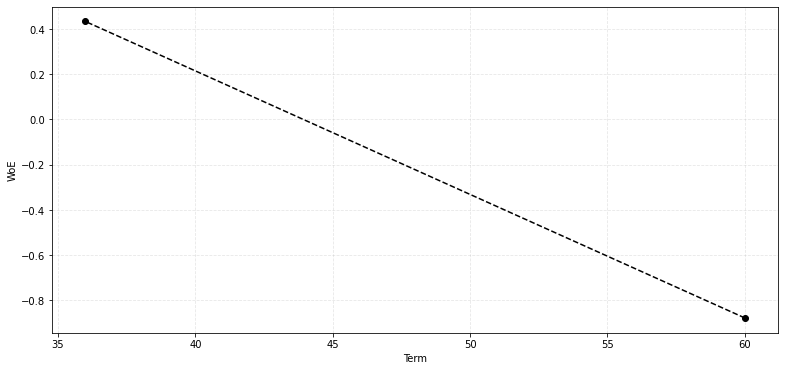

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='term',
    target_column_name=TARGET_VARIABLE,
)

2. emp_length

same as term, emp_lengt need to convert to numerical values

In [ ]:
print(f"{train_df['emp_length'].isnull().mean()*100:.2f}% missing!\n\n")
print(train_df['emp_length'].unique())
print(train_df['emp_length'].value_counts())

0.00% missing!


['1 year' '10+ years' '4 years' '8 years' '7 years' '2 years' '6 years'
 '5 years' '0' '9 years' '3 years' '< 1 year']
10+ years    153647
2 years       41314
< 1 year      38376
3 years       36665
1 year        30104
0             29246
5 years       27570
4 years       27324
8 years       20789
7 years       19327
6 years       18862
9 years       17116
Name: emp_length, dtype: int64


In [ ]:
mapping = {
    '0': 0,
    '< 1 year': 1,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

# Apply the mapping to convert the values
train_df['emp_length'] = train_df['emp_length'].map(mapping)

IV value: 0.06916085714030114


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
emp_length,,,,,,,
0,14306,14940,29246,0.072823,0.056614,-0.251779,0.006287
6,8178,10684,18862,0.041629,0.040486,-0.027842,0.006287
4,11839,15485,27324,0.060265,0.058679,-0.026670,0.006287
3,15709,20956,36665,0.079965,0.079411,-0.006951,0.006287
5,11778,15792,27570,0.059955,0.059843,-0.001872,0.006287
10,65285,88362,153647,0.332327,0.334842,0.007538,0.006287
1,29088,39392,68480,0.148070,0.149273,0.008095,0.006287
2,17487,23827,41314,0.089016,0.090291,0.014219,0.006287
7,7890,11437,19327,0.040163,0.043340,0.076115,0.006287


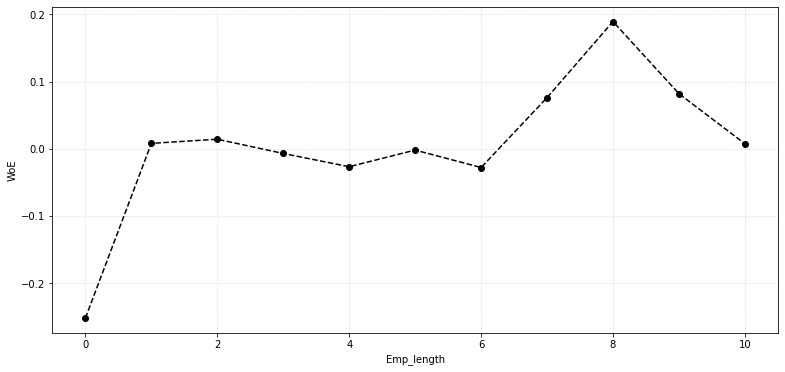

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='emp_length',
    target_column_name=TARGET_VARIABLE,
)

3. int_rate

In [ ]:
print(f"{train_df['int_rate'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['int_rate'].unique()))
print(train_df['int_rate'].value_counts())

0.00% missing!


[5.31, 5.32, 5.93, 6.0, 6.03, 6.07, 6.08, 6.24, 6.39, 6.49, 6.68, 6.71, 6.72, 6.89, 6.92, 6.99, 7.07, 7.21, 7.26, 7.34, 7.35, 7.49, 7.89, 7.91, 7.96, 7.97, 8.18, 8.19, 8.38, 8.49, 8.67, 9.17, 9.43, 9.44, 9.49, 9.76, 9.8, 9.92, 9.93, 9.99, 10.41, 10.42, 10.49, 10.64, 10.78, 10.9, 10.91, 10.99, 11.22, 11.44, 11.48, 11.49, 11.53, 11.98, 11.99, 12.05, 12.29, 12.39, 12.59, 12.61, 12.62, 12.69, 12.88, 12.99, 13.18, 13.33, 13.44, 13.58, 13.59, 13.66, 13.67, 13.99, 14.07, 14.08, 14.31, 14.33, 14.48, 14.65, 14.85, 14.99, 15.04, 15.05, 15.41, 15.59, 15.61, 15.77, 15.99, 16.01, 16.02, 16.49, 16.55, 16.59, 16.9, 16.99, 17.09, 17.14, 17.27, 17.47, 17.57, 17.86, 17.97, 18.06, 18.2, 18.25, 18.45, 18.49, 18.54, 18.55, 18.84, 18.99, 19.03, 19.19, 19.24, 19.42, 19.48, 19.52, 19.89, 19.99, 20.0, 20.39, 20.49, 20.5, 20.99, 21.45, 21.48, 21.67, 21.85, 21.99, 22.45, 22.9, 22.91, 22.99, 23.13, 23.87, 23.88, 23.99, 24.24, 24.5, 24.84, 24.85, 24.99, 25.09, 25.57, 25.78, 25.8, 25.81, 25.82, 25.

In [ ]:
bins = [0, 9.6, 13.9, 18.2, 22.4, 26.7, 33]

labels = ['0-9.6%', '9.6-13.9%', '13.9-18.2%', '18.2-22.4%', '22.4-26.7%', '25-33%']

train_df['int_rate_category'] = pd.cut(train_df['int_rate'], bins=bins, labels=labels)

IV value: 1.0721951630555229


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
int_rate_category,,,,,,,
25-33%,2071,824,2895,0.010542,0.003122,-1.216758,0.178699
22.4-26.7%,7469,3770,11239,0.038020,0.014286,-0.978828,0.178699
18.2-22.4%,23777,15589,39366,0.121035,0.059073,-0.717295,0.178699
13.9-18.2%,55115,54710,109825,0.280558,0.207320,-0.302518,0.178699
9.6-13.9%,68946,98507,167453,0.350963,0.373285,0.061662,0.178699
0-9.6%,39070,90492,129562,0.198882,0.342913,0.544764,0.178699


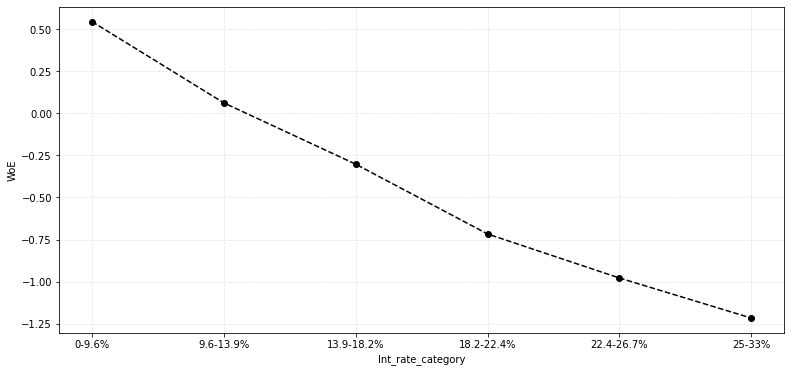

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='int_rate_category',
    target_column_name=TARGET_VARIABLE,
)

4. funded_amnt

In [ ]:
print(f"{train_df['funded_amnt'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['funded_amnt'].unique()))
print(train_df['funded_amnt'].value_counts())

0.00% missing!


[1000.0, 1025.0, 1050.0, 1075.0, 1100.0, 1125.0, 1150.0, 1175.0, 1200.0, 1225.0, 1250.0, 1275.0, 1300.0, 1325.0, 1350.0, 1375.0, 1400.0, 1425.0, 1450.0, 1475.0, 1500.0, 1525.0, 1550.0, 1575.0, 1600.0, 1625.0, 1650.0, 1675.0, 1700.0, 1725.0, 1750.0, 1775.0, 1800.0, 1825.0, 1850.0, 1875.0, 1900.0, 1925.0, 1950.0, 1975.0, 2000.0, 2025.0, 2050.0, 2075.0, 2100.0, 2125.0, 2150.0, 2175.0, 2200.0, 2225.0, 2250.0, 2275.0, 2300.0, 2325.0, 2350.0, 2375.0, 2400.0, 2425.0, 2450.0, 2475.0, 2500.0, 2525.0, 2550.0, 2575.0, 2600.0, 2625.0, 2650.0, 2675.0, 2700.0, 2725.0, 2750.0, 2775.0, 2800.0, 2825.0, 2850.0, 2875.0, 2900.0, 2925.0, 2950.0, 2975.0, 3000.0, 3025.0, 3050.0, 3075.0, 3100.0, 3125.0, 3150.0, 3175.0, 3200.0, 3225.0, 3250.0, 3275.0, 3300.0, 3325.0, 3350.0, 3375.0, 3400.0, 3425.0, 3450.0, 3475.0, 3500.0, 3525.0, 3550.0, 3575.0, 3600.0, 3625.0, 3650.0, 3675.0, 3700.0, 3725.0, 3750.0, 3775.0, 3800.0, 3825.0, 3850.0, 3875.0, 3900.0, 3925.0, 3950.0, 3975.0, 4000.0, 4025.0, 4050.0

In [ ]:
bins = [900, 8800, 16600, 24400, 32200, 40000]

labels = ['900-8800', '8800-16600', '16600-24400', '32200-32200', '32200-40000']

train_df['funded_amnt_category'] = pd.cut(train_df['funded_amnt'], bins=bins, labels=labels)

IV value: 0.3658855850343739


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
funded_amnt_category,,,,,,,
32200-40000,15698,13283,28981,0.079909,0.050335,-0.462190,0.073177
32200-32200,25648,25559,51207,0.130559,0.096854,-0.298618,0.073177
16600-24400,43350,48479,91829,0.220669,0.183708,-0.183318,0.073177
8800-16600,72137,96124,168261,0.367207,0.364255,-0.008070,0.073177
900-8800,39615,80447,120062,0.201656,0.304848,0.413249,0.073177


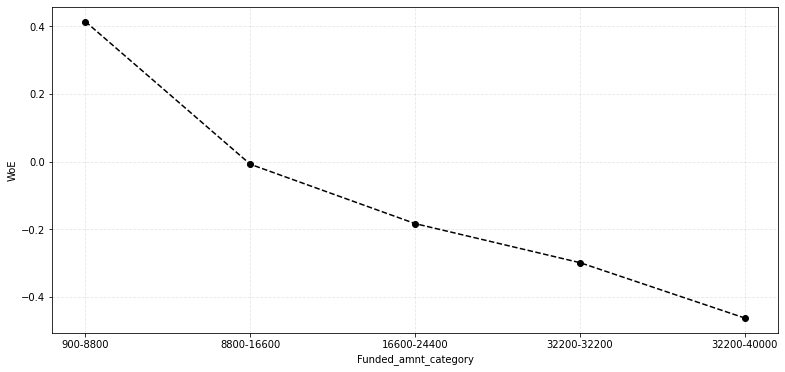

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='funded_amnt_category',
    target_column_name=TARGET_VARIABLE,
)

5. annual_inc

In [ ]:
print(f"{train_df['annual_inc'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['annual_inc'].unique()))
print(train_df['annual_inc'].value_counts())

0.00% missing!


[0.0, 15.0, 33.0, 40.0, 60.0, 100.0, 138.0, 150.0, 191.0, 250.0, 300.0, 400.0, 500.0, 600.0, 640.0, 750.0, 800.0, 850.0, 886.0, 929.0, 938.0, 1000.0, 1100.0, 1200.0, 1288.78, 1320.0, 1370.0, 1400.0, 1750.0, 1800.0, 1968.0, 2000.0, 2100.0, 2200.0, 2400.0, 2500.0, 2940.0, 3000.0, 3120.0, 3181.0, 3200.0, 3378.0, 3400.0, 3500.0, 3600.0, 3700.0, 3800.0, 3804.0, 4000.0, 4002.0, 4300.0, 4392.0, 4412.0, 4476.0, 4500.0, 4524.0, 4600.0, 4740.0, 4800.0, 4992.0, 5000.0, 5088.0, 5200.0, 5208.0, 5235.0, 5360.0, 5400.0, 5416.0, 5440.0, 5600.0, 5694.0, 5700.0, 6000.0, 6078.0, 6200.0, 6240.0, 6252.0, 6300.0, 6424.0, 6500.0, 6564.0, 6600.0, 6635.0, 6650.0, 6736.0, 6800.0, 6864.0, 6901.0, 7000.0, 7067.0, 7196.0, 7200.0, 7224.0, 7225.0, 7247.0, 7255.0, 7356.0, 7500.0, 7596.0, 7749.0, 7776.0, 7788.0, 7800.0, 7858.0, 7900.0, 7917.0, 7932.0, 8000.0, 8057.0, 8064.0, 8100.0, 8112.0, 8140.0, 8160.0, 8172.0, 8200.0, 8244.0, 8262.0, 8300.0, 8304.0, 8328.0, 8374.0, 8391.48, 8400.0, 8500.0, 8550.0,

In [ ]:
bins = [20000, 30000, 70000, 80000, 90000, 100000, 120000, 140000]

labels = ['20000-30000', '30000-70000', '70000-80000',
          '80000-90000', '90000-100000', '100000-120000', '120000-140000']

train_df['annual_inc_category'] = pd.cut(train_df['annual_inc'], bins=bins, labels=labels)

IV value: 0.006349654605732641


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
annual_inc_category,,,,,,,
20000-30000,11410,14866,26276,0.064055,0.062079,-0.031339,0.000907
30000-70000,97828,128826,226654,0.549201,0.537963,-0.020674,0.000907
70000-80000,19635,26650,46285,0.110230,0.111287,0.009550,0.000907
80000-90000,14553,20049,34602,0.081700,0.083722,0.024456,0.000907
90000-100000,12087,16783,28870,0.067856,0.070084,0.032310,0.000907
120000-140000,8080,11456,19536,0.045361,0.047839,0.053196,0.000907
100000-120000,14535,20840,35375,0.081599,0.087026,0.064389,0.000907


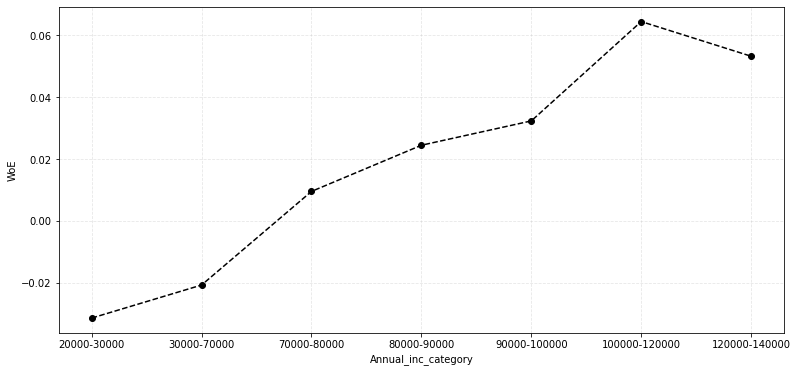

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='annual_inc_category',
    target_column_name=TARGET_VARIABLE,
)

6. delinq_2yrs

In [ ]:
print(f"{train_df['delinq_2yrs'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['delinq_2yrs'].unique()))
print(train_df['delinq_2yrs'].value_counts())

0.00% missing!


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 26.0, 28.0, 30.0, 39.0]
0.0     370855
1.0      59227
2.0      17512
3.0       6301
4.0       2885
5.0       1445
6.0        815
7.0        426
8.0        269
9.0        178
10.0       139
11.0        89
12.0        63
13.0        37
14.0        34
15.0        25
16.0        12
17.0         8
18.0         6
19.0         5
20.0         3
26.0         2
28.0         1
39.0         1
30.0         1
22.0         1
Name: delinq_2yrs, dtype: int64


In [ ]:
bins = [0, 13.0, 19.5, 26.0]

labels = ['0-13.0', '13.0-19.5', '19.5-26.0']

train_df['delinq_2yrs_category'] = pd.cut(train_df['delinq_2yrs'], bins=bins, labels=labels)

IV value: 0.00013198407370745095


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
delinq_2yrs_category,,,,,,,
0-13.0,36867,52519,89386,0.999052,0.998840,-0.000212,0.000044
13.0-19.5,33,57,90,0.000894,0.001084,0.192474,0.000044
19.5-26.0,2,4,6,0.000054,0.000076,0.339077,0.000044


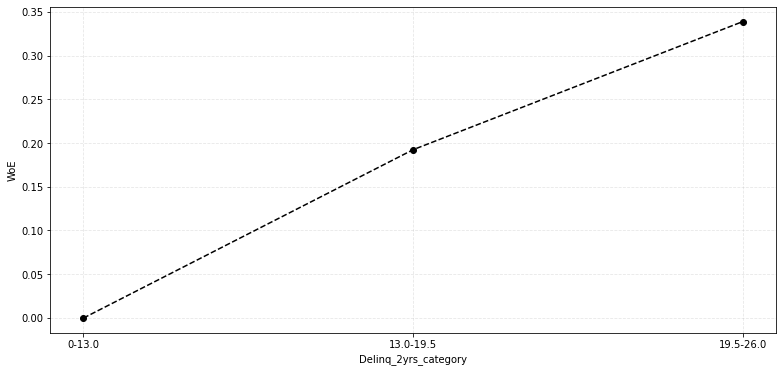

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='delinq_2yrs_category',
    target_column_name=TARGET_VARIABLE,
)s

7. inq_last_6mths

In [ ]:
print(f"{train_df['inq_last_6mths'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['inq_last_6mths'].unique()))
print(train_df['inq_last_6mths'].value_counts())

0.00% missing!


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
0.0    285787
1.0    119166
2.0     38499
3.0     12729
4.0      3062
5.0      1063
6.0        34
Name: inq_last_6mths, dtype: int64


In [ ]:
bins = [0.0, 4.0, 6.0]

labels = ['0.0-4.0', '4.0-6.0']

train_df['inq_last_6mths_category'] = pd.cut(train_df['inq_last_6mths'], bins=bins, labels=labels)

IV value: 0.000497925289580147


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
inq_last_6mths_category,,,,,,,
0.0-4.0,73851,99605,173456,0.994425,0.99319,-0.001243,0.000249
4.0-6.0,414,683,1097,0.005575,0.00681,0.200223,0.000249


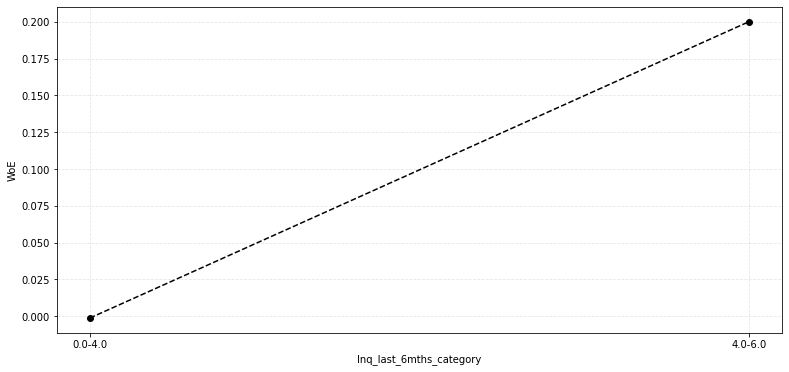

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='inq_last_6mths_category',
    target_column_name=TARGET_VARIABLE,
)

8. open_acc

In [ ]:
print(f"{train_df['open_acc'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['open_acc'].unique()))
print(train_df['open_acc'].value_counts())

0.00% missing!


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 62.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 74.0, 76.0, 79.0, 90.0]
9.0     39266
10.0    38278
8.0     37504
11.0    35458
7.0     33963
        ...  
64.0        1
62.0        1
68.0        1
90.0        1
79.0        1
Name: open_acc, Length: 73, dtype: int64


IV value: 0.4270172834550909


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
open_acc,,,,,,,
60.0,3.0,1.0,4.0,0.000015,0.000004,-1.393754,0.00585
59.0,3.0,1.0,4.0,0.000015,0.000004,-1.393754,0.00585
1.0,230.0,80.0,310.0,0.001171,0.000303,-1.351195,0.00585
50.0,6.0,3.0,9.0,0.000031,0.000011,-0.988289,0.00585
49.0,13.0,7.0,20.0,0.000066,0.000027,-0.914181,0.00585
...,...,...,...,...,...,...,...
70.0,NaN,1.0,1.0,NaN,0.000004,NaN,0.00585
74.0,NaN,1.0,1.0,NaN,0.000004,NaN,0.00585
76.0,NaN,1.0,1.0,NaN,0.000004,NaN,0.00585


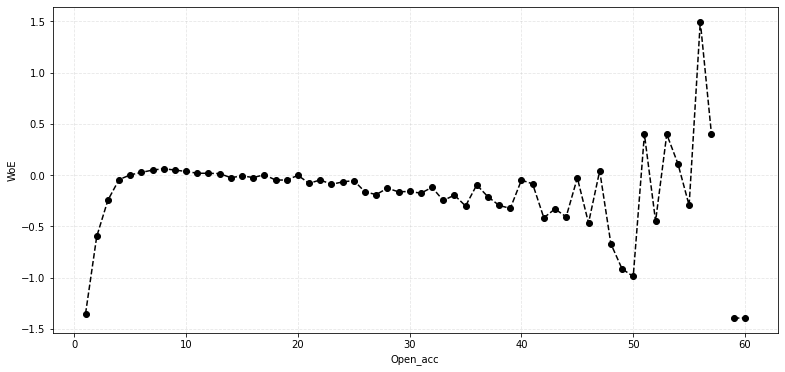

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='open_acc',
    target_column_name=TARGET_VARIABLE,
)

9. pub_rec

In [ ]:
print(f"{train_df['pub_rec'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['pub_rec'].unique()))
print(train_df['pub_rec'].value_counts())

0.00% missing!


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 26.0, 49.0, 52.0, 86.0]
0.0     383104
1.0      64308
2.0       8353
3.0       2646
4.0        996
5.0        429
6.0        221
7.0         89
8.0         79
9.0         31
10.0        24
12.0        13
11.0        12
13.0        10
15.0         4
18.0         3
16.0         3
21.0         3
19.0         2
17.0         2
14.0         1
26.0         1
23.0         1
86.0         1
52.0         1
49.0         1
22.0         1
20.0         1
Name: pub_rec, dtype: int64


In [ ]:
bins = [0, 1, 16]

labels = ['0-1', '1-16']

train_df['pub_rec_category'] = pd.cut(train_df['pub_rec'], bins=bins, labels=labels)

IV value: 0.013660519145239296


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
pub_rec_category,,,,,,,
0-1,26594,37714,64308,0.851008,0.820422,-0.036602,0.00683
1-16,4656,8255,12911,0.148992,0.179578,0.186714,0.00683


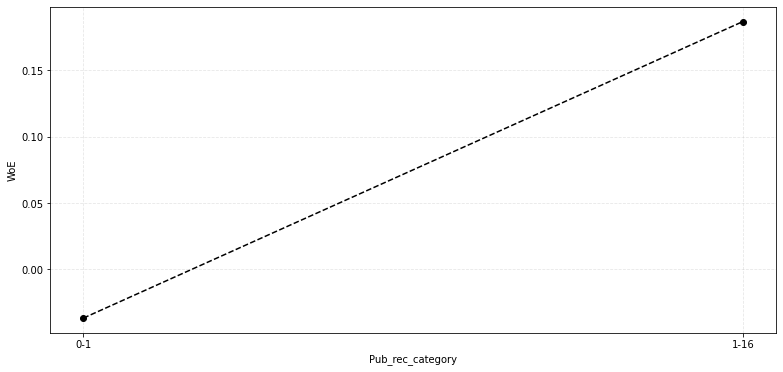

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='pub_rec_category',
    target_column_name=TARGET_VARIABLE,
)

10. total_acc

In [ ]:
print(f"{train_df['total_acc'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['total_acc'].unique()))
print(train_df['total_acc'].value_counts())

0.00% missing!


[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 124.0, 125.0, 126.0, 127.0, 130.0, 133.0, 135.0, 136.0, 137.0, 138.0, 141.0, 146.0, 151.0, 153.0, 162.0, 169.0]
20.0     16579
21.0     16397
19.0     16373
18.0     16286
22.0     16254
         ...  
162.0        1
115.0        1
169.0        1
126.0        1
117.0        1

In [ ]:
bins = [0, 60, 100, 120]

labels = ['0-60', '60-100', '100-120']

train_df['total_acc_category'] = pd.cut(train_df['total_acc'], bins=bins, labels=labels)

IV value: 0.0003736958368200984


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
total_acc_category,,,,,,,
0-60,194491,260964,455455,0.990078,0.988942,-0.001148,0.000125
60-100,1928,2886,4814,0.009815,0.010937,0.108243,0.000125
100-120,21,32,53,0.000107,0.000121,0.126068,0.000125


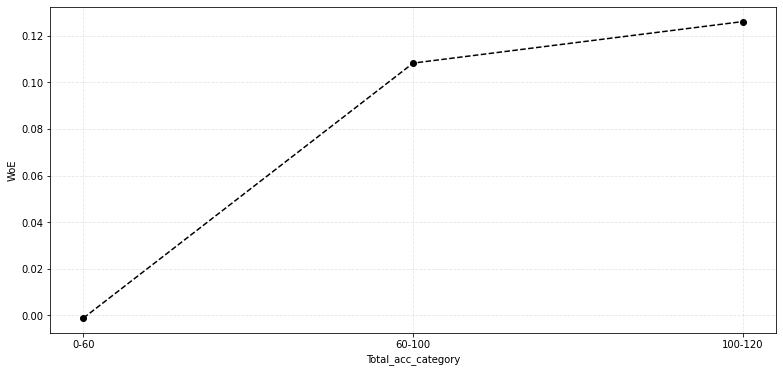

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='total_acc_category',
    target_column_name=TARGET_VARIABLE,
)

11. dti

In [ ]:
print(f"{train_df['dti'].isnull().mean()*100:.2f}% missing!\n\n")
print(sorted(train_df['dti'].unique()))
print(train_df['dti'].value_counts())

0.00% missing!


[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.6

In [ ]:
train_df['dti_category'] = pd.cut(train_df['dti'], bins=4)

# If you want to label these categories as string ranges
train_df['dti_category'] = train_df['dti_category'].apply(lambda x: f'{x.left}_{x.right}')

IV value: 0.0024569447463767082


,Non Default,Default,Total Obs,% Non Default,% Default,WoE,IV
dti_category,,,,,,,
249.75_499.5,50,9,59,0.000255,0.000034,-2.009941,0.000614
749.25_999.0,22,7,29,0.000112,0.000027,-1.440274,0.000614
499.5_749.25,9,3,12,0.000046,0.000011,-1.393754,0.000614
-0.999_249.75,196367,263873,460240,0.999588,0.999928,0.000340,0.000614


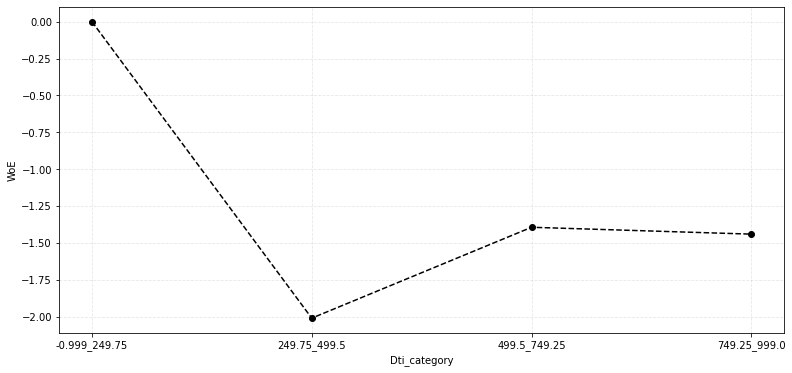

In [ ]:
display_woe(
    df=train_df,
    id_column_name="id",
    feature_column_name='dti_category',
    target_column_name=TARGET_VARIABLE,
)